# Goal

Can the data answer the question?

-- DS: optimise customer experience by tailoring cnotent to user needs (identify behaviour patterns)

-- ML: difficulty finding content (identify 404 patterns) (identify opportunity to improve)

## Understanding variables

Parameters described here: https://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html

### Load data to dataframe

Declaring analysis variables

In [2]:
import pandas as pd
import numpy as np
import os
import re

folder_raw_data = '../data/raw'
folder_clean_data = '../data/cleaned'
symbols_dirty = re.compile(' -0400| -|\[|\]')
raw_encoding='iso-8859-1'

cols_raw_log = ['host', 'timestamp', 'request', 'response', 'bytes']
dtype_cols_raw_log = {'host': str, 'timestamp': np.datetime64, 'request': str, 'response': str, 'bytes': np.int64}

Need to clean data from unnecessary dashes so the tsv parsing would be more straightforward.

In [3]:
def clean_raw_logs(file):
    with open(folder_clean_data + '/' + file, 'w', encoding=raw_encoding) as c:
        with open(folder_raw_data + '/' + file, 'r', encoding=raw_encoding) as r:
            for log_line in r:
                log_line = symbols_dirty.sub('', log_line)
                c.write(log_line)

Ensuring adherence to data type

In [4]:
def apply_data_type(df_logs):
    df_logs['timestamp'] = pd.to_datetime(df_logs['timestamp'], format='%d/%b/%Y:%H:%M:%S')
    df_logs['bytes'] = df_logs['bytes'].fillna(0)
    df_logs = df_logs.astype(dtype_cols_raw_log)
    return df_logs

Loading the raw logs and converting in an expected dataframe output

In [5]:
def load_logs():
    files = os.listdir(folder_raw_data)
    files = [file for file in files if os.path.isfile(folder_raw_data + '/' + file)]
    df_logs = pd.DataFrame(columns=cols_raw_log)
    for file in files:
        clean_raw_logs(file)
        df_log = pd.read_csv(folder_clean_data + '/' + file, sep=' ', encoding=raw_encoding, header=None, names=cols_raw_log, 
                             on_bad_lines='skip') #'warn')
        df_log = apply_data_type(df_log)
        df_logs = pd.concat([df_logs, df_log], axis=0)
    return df_logs

df_loaded_logs = load_logs()


/var/folders/xr/9y_qxq8j3mzgvbyy734y4_pc0000gn/T/ipykernel_38959/2534735201.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_log = pd.read_csv(folder_clean_data + '/' + file, sep=' ', encoding=raw_encoding, header=None, names=cols_raw_log,
/var/folders/xr/9y_qxq8j3mzgvbyy734y4_pc0000gn/T/ipykernel_38959/2534735201.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_log = pd.read_csv(folder_clean_data + '/' + file, sep=' ', encoding=raw_encoding, header=None, names=cols_raw_log,


In [6]:
df_loaded_logs.head()

,host,timestamp,request,response,bytes
0,199.72.81.55,1995-07-01 00:00:01,GET /history/apollo/ HTTP/1.0,200,6245
1,unicomp6.unicomp.net,1995-07-01 00:00:06,GET /shuttle/countdown/ HTTP/1.0,200,3985
2,199.120.110.21,1995-07-01 00:00:09,GET /shuttle/missions/sts-73/mission-sts-73.ht...,200,4085
3,burger.letters.com,1995-07-01 00:00:11,GET /shuttle/countdown/liftoff.html HTTP/1.0,304,0
4,199.120.110.21,1995-07-01 00:00:11,GET /shuttle/missions/sts-73/sts-73-patch-smal...,200,4179


In [7]:
df_loaded_logs.dtypes

host         object
timestamp    object
request      object
response     object
bytes        object
dtype: object

## Clean dataset and identify features

Identifying important variables in terms of answering the questions:
1. *host*: identifying requester (to be used for grouping later).
2. *timestamp*: indicator for specific times where experience was bad. 
    * To be used for grouping per day, hour, minutes. 
    * Year is irrelevant (as dataset is limited), but will be kept for flexibility.
3. *request*: identifying the pages viewed/requested.
    * Request method
    * URL traversal path
    * Page OR Resource OR None
    * HTTP/1.0 is irrelevant (doesn't give insight because all requests use it for this dataset)
4. *response*: identifies response codes
    * nominal: success, redirect, not found
    * more indicator may be needed to identify points for improvement. refer to https://en.wikipedia.org/wiki/List_of_HTTP_status_codes
5. *bytes*: marginally irrelevant, except for explaining why certain pages may take a long time to load (however there are no other captured information available to validate this).
    * threshold indicator to build case for potential point for improvement: CDN

These will then be formed to data features

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import calendar
from http import HTTPStatus

folder_clean_data = '../data/cleaned'
raw_encoding='iso-8859-1'

cols_raw_log = ['host', 'timestamp', 'request', 'response', 'bytes']
dtype_cols_raw_log = {'host': str, 'timestamp': np.datetime64, 'request': str, 'response': str, 'bytes': np.int64}

def apply_data_type(df_logs):
    df_logs['timestamp'] = pd.to_datetime(df_logs['timestamp'], format='%d/%b/%Y:%H:%M:%S')
    df_logs['bytes'] = df_logs['bytes'].fillna(0)
    df_logs = df_logs.astype(dtype_cols_raw_log)
    return df_logs

def load_cleaned_logs():
    files = os.listdir(folder_clean_data)
    files = [file for file in files if os.path.isfile(folder_clean_data + '/' + file)]
    df_logs = pd.DataFrame(columns=cols_raw_log)
    for file in files:
        df_log = pd.read_csv(folder_clean_data + '/' + file, sep=' ', encoding=raw_encoding, header=None, names=cols_raw_log, 
                             on_bad_lines='skip') #'warn')
        df_logs = pd.concat([df_logs, df_log], axis=0)
    return apply_data_type(df_logs)

df_cleaned_logs = load_cleaned_logs()
df_cleaned_logs.nunique(axis=0)

/var/folders/xr/9y_qxq8j3mzgvbyy734y4_pc0000gn/T/ipykernel_17143/2085723300.py:27: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_log = pd.read_csv(folder_clean_data + '/' + file, sep=' ', encoding=raw_encoding, header=None, names=cols_raw_log,
/var/folders/xr/9y_qxq8j3mzgvbyy734y4_pc0000gn/T/ipykernel_17143/2085723300.py:27: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_log = pd.read_csv(folder_clean_data + '/' + file, sep=' ', encoding=raw_encoding, header=None, names=cols_raw_log,


host          137979
timestamp    2075518
request        32845
response          15
bytes          16502
dtype: int64

### Host

* Insight idea: categorise the type of visitor based on url (e.g. government, education, commercial, etc)
* Add Domain column
* Insight idea: identify visiting countries

In [2]:
def get_visitor_domain(url):
    try:
        domain_index = url.rindex('.')
        domain = str(url[(domain_index + 1) :])
        if domain.isdigit():
            domain = None
    except:
        domain = None
    return domain

def categorise_visitor(domain):
    switcher = {
        'net': 'network',
        'com': 'commercial',
        'org': 'organisation',
        'edu': 'education',
        'gov': 'government',
        'int': 'international',
    }
    domain_length = len(domain)
    try:
        if domain_length == 2:
            category = 'country'
        elif domain_length == 3:
            category = switcher.get(domain, 'unknown')
        else:
            category = 'unknown'
    except:
        category = 'unknown'
    return category

In [3]:
# create a new df to show who are the visitors
df_visitors = pd.DataFrame(df_cleaned_logs['host'])

# identify visitor profile through domain
df_visitors['domain'] = df_visitors['host'].apply(get_visitor_domain).map(lambda x: str(x))
print('unique domains: ', df_visitors['domain'].unique())

df_visitors['category'] = df_visitors['domain'].apply(categorise_visitor).map(lambda x: str(x))
df_visitors.nunique(axis=0)

unique domains:  ['None' 'net' 'com' 'jp' 'au' 'edu' 'ca' 'org' 'gov' 'us' 'nz' 'uk' 'kr'
 'ch' 'br' 'sg' 'it' 'mil' 'mx' 'nl' 'be' 'za' 'fr' 'de' 'my' 'tw' 'at'
 'fi' 'se' 'id' 'il' 'es' 'no' 'int' 'su' 'ph' 'ie' 'th' 'gr' 'pt' 'dk'
 'kw' 'ru' 'cl' 'cz' 'lv' 'arpa' 'lu' 'cr' 'co' 'tr' 'hr' 'bm' 'ua' 've'
 'si' 'cn' 'ro' 'pl' 'hk' 'sk' 'is' 'ec' 'hu' 'gb' 'sa' 'li' 'ar' 'pa'
 'pr' 'jm' 'in' 'ee' 'do' 'pe' 'fj' 'uy' 'xom' 'go' 'eg' 'ge' 'p' 'microd'
 'mt' 'keri' 'rom' 'hps' 'gl' 'gu' 'cy' 'eecs' 'line4' 'line5' 'lt']


host        137979
domain          94
category         8
dtype: int64

#### Top visitors (ranked)

In [4]:
# group by and count number of visits
df_top_visitors = df_visitors.groupby(['host'])['host'].count().sort_values(ascending=False)
df_top_visitors

host
piweba3y.prodigy.com              21988
piweba4y.prodigy.com              16437
piweba1y.prodigy.com              12825
edams.ksc.nasa.gov                11964
163.206.89.4                       9697
                                  ...  
cu-dialup-1020.cit.cornell.edu        1
141.211.112.25                        1
161.119.239.163                       1
kra.tiac.net                          1
ds11.analogy.com                      1
Name: host, Length: 137979, dtype: int64

#### Type of visitors (distribution)
1. Commercial
2. Unknown - contains miscellaneous (e.g. CDN) request, unfamiliar domains, IP addresses
3. Country - based on country-level top domain
4. Education

Interestingly, Government site visitors are on the 6th order.

/var/folders/xr/9y_qxq8j3mzgvbyy734y4_pc0000gn/T/ipykernel_17143/1626320225.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


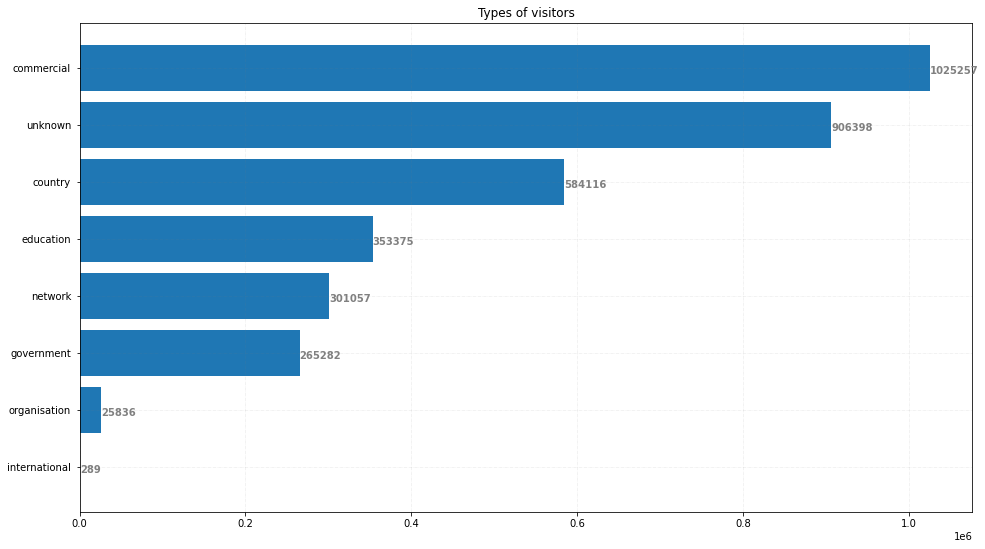

In [5]:
# group by and count number of visits
df_top_visitors = df_visitors.groupby(['category'])['category'].count().sort_values(ascending=False).reset_index(name='count')

# horizontal bar plot
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(df_top_visitors['category'], df_top_visitors['count'])
# add padding for better visibility
ax.xaxis.set_tick_params(pad = 3)
ax.yaxis.set_tick_params(pad = 5)
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# sort descending order
ax.invert_yaxis()
# Add annotation to bars
for i in ax.patches:   
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey') 
# Add Plot Title
ax.set_title('Types of visitors') 
plt.show()


Visiting countries (represents only a SUBSET based on identifiable country top-level domain):
1. Canada
2. UK
3. Japan
4. Australia
5. Germany


/var/folders/xr/9y_qxq8j3mzgvbyy734y4_pc0000gn/T/ipykernel_17143/3053753967.py:13: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


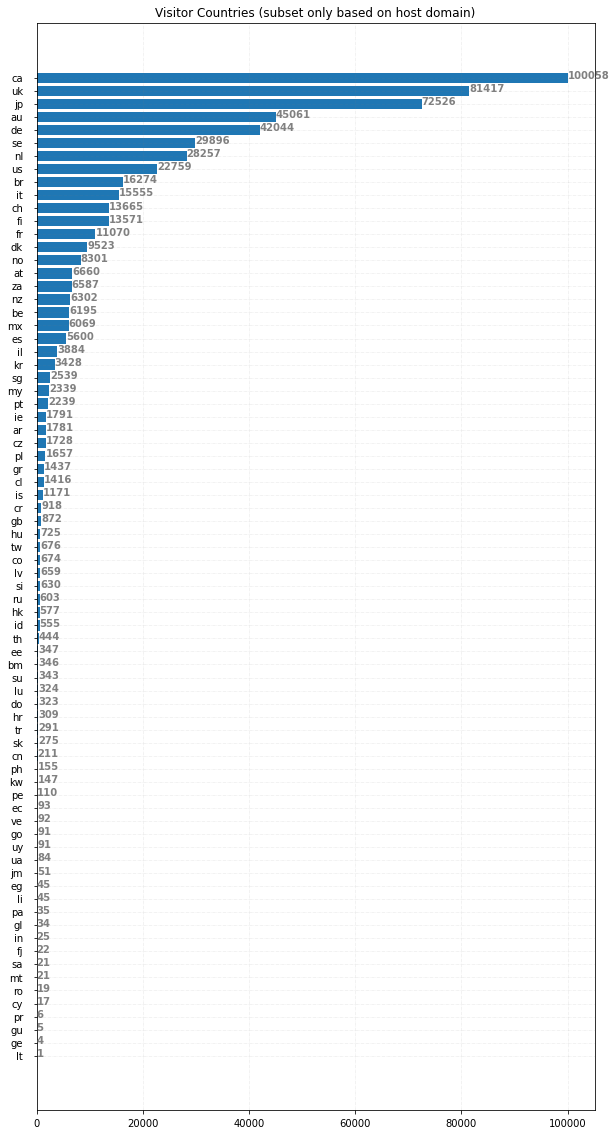

In [6]:
df_visitor_country = df_visitors.loc[df_visitors['category'] == 'country']
df_visitor_country = df_visitor_country.filter(['domain'])
df_visitor_country = df_visitor_country.groupby(['domain'])['domain'].count().sort_values(ascending=False).reset_index(name='count')
df_visitor_country.head()

# horizontal bar plot
fig, ax = plt.subplots(figsize =(10, 20))
ax.barh(df_visitor_country['domain'], df_visitor_country['count'])
# add padding for better visibility
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# sort descending order
ax.invert_yaxis()
# Add annotation to bars
for i in ax.patches:   
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey') 
# Add Plot Title
ax.set_title('Visitor Countries (subset only based on host domain)') 
plt.show()

In [7]:
# Dataframe resulting from host analysis
df_visitors

,host,domain,category
0,199.72.81.55,None,unknown
1,unicomp6.unicomp.net,net,network
2,199.120.110.21,None,unknown
3,burger.letters.com,com,commercial
4,199.120.110.21,None,unknown
...,...,...,...
1569891,gatekeeper.uccu.com,com,commercial
1569892,gatekeeper.uccu.com,com,commercial
1569893,cys-cap-9.wyoming.com,com,commercial
1569894,www-c8.proxy.aol.com,com,commercial


### Timestamp
* Add Month column
* Add Day column
* Add Hour column
* Add Mins column
* Nominal category: AM or PM
* Nominal category: day of the week
* Insight idea: show trends based on:
    * busiest day of all time (within 2 months of 1995)
    * most visited day in a week
    * busiest hour in a day (can help inform the right time for website updates)

In [8]:
# create a new df for breaking down timestamp
df_timestamp = pd.DataFrame(df_cleaned_logs['timestamp'])

df_timestamp['date'] = df_timestamp['timestamp'].dt.date

# extract month, date, hour, minutes, day of week
df_timestamp['month'] = df_timestamp['timestamp'].dt.month
df_timestamp['day'] = df_timestamp['timestamp'].dt.day
df_timestamp['hour'] = df_timestamp['timestamp'].dt.hour
df_timestamp['minutes'] = df_timestamp['timestamp'].dt.minute
df_timestamp['dayofweek'] = df_timestamp['timestamp'].dt.day_of_week

# Get a map to translate month
m = dict(zip(range(12),list(calendar.month_name)))
df_timestamp['month'] = df_timestamp['month'].map(m)

# Get a map to translate to day of week
d = dict(zip(range(7),list(calendar.day_name)))
df_timestamp['dayofweek'] = df_timestamp['dayofweek'].map(d)

# AM/PM category
df_timestamp['dayperiod'] = df_timestamp['hour'].apply(lambda x: 'AM' if x < 12 else 'PM')

# output of this will validate it looks right
df_timestamp.nunique(axis=0)

timestamp    2075518
date              58
month              2
day               31
hour              24
minutes           60
dayofweek          7
dayperiod          2
dtype: int64

#### Trend Analysis

The busiest days across the 2 month data set -- **TODO: try to see and explain what happened on those days**

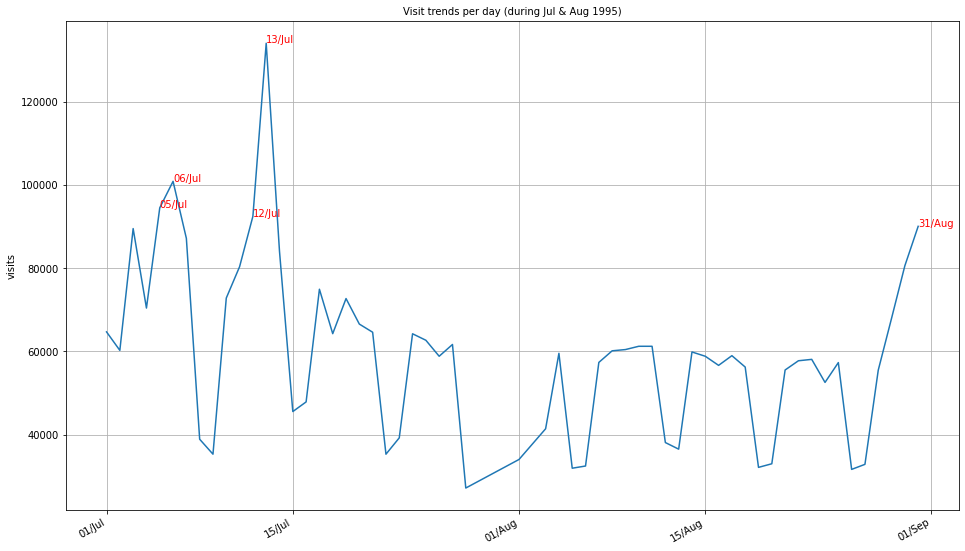

In [9]:
df_timestamp_days = df_timestamp.groupby(['date'])['date'].count().reset_index(name='visits')

# plot line chart
fig, ax = plt.subplots(figsize =(16, 9))
ax.plot(df_timestamp_days['date'], df_timestamp_days['visits'])

# Major ticks every half-month
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=(1, 15)))
ax.grid(True)
ax.set_ylabel('visits')
ax.set_title('Visit trends per day (during Jul & Aug 1995)', fontsize='medium')
# Text in the x-axis.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%b'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

#annotate pertinent dates in data with visits greater than 90k
annotated_data = df_timestamp_days[df_timestamp_days['visits'] > 90000]
# Annotate data points
for index, row in annotated_data.iterrows():
    ax.annotate(row['date'].strftime('%d/%b'), 
                xy=(row['date'], row['visits']), color='red')

plt.show()

Days of the week access trends
* Thursdays are the busiest on both months -- **TODO: try to analyse on the type of requests**
* Weekends are relatively quieter than the weekdays

Text(0.5, 1.0, 'Day of week visit trends (during Jul & Aug 1995)')

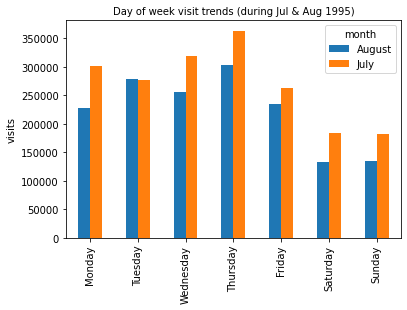

In [10]:
df_timestamp_days = df_timestamp.groupby(['dayofweek', 'month'])['dayofweek'].count().reset_index(name='visits')

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = pd.pivot_table(df_timestamp_days.reset_index(),
               index='dayofweek', columns='month', values='visits'
              ).loc[day_order].plot(kind='bar')

ax.set_ylabel('visits')
ax.set_xlabel('')
ax.set_title('Day of week visit trends (during Jul & Aug 1995)', fontsize='medium')

Hours in a day access trends
* Follows standard business hours activity (between 8am - 6pm)
* Busiest late after lunch
* Least activity on wee hours of the morning (4 - 6am) -- best time to do any patches
    * however, worthwhile to do further digging on the sites frequently visited during these timeframe to aid update rollouts.

Text(0.5, 1.0, 'Hour of day visit trends (during Jul & Aug 1995)')

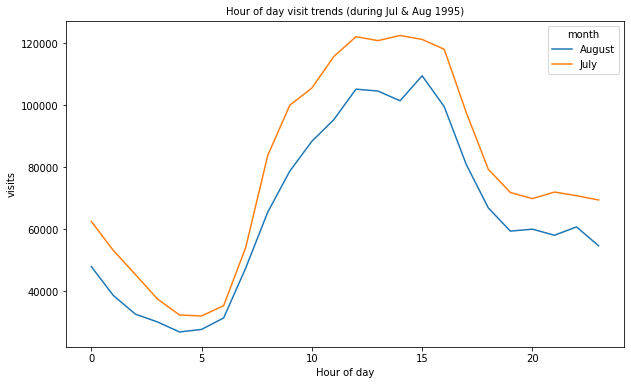

In [11]:
df_timestamp_days = df_timestamp.groupby(['hour', 'month'])['hour'].count().reset_index(name='visits')

ax = pd.pivot_table(df_timestamp_days.reset_index(),
               index='hour', columns='month', values='visits'
              ).plot(kind='line')

ax.figure.set_size_inches(10, 6)
ax.set_ylabel('visits')
ax.set_xlabel('Hour of day')
ax.set_title('Hour of day visit trends (during Jul & Aug 1995)', fontsize='medium')

In [12]:
# Dataframe resulting from timestamp analysis
df_timestamp

,timestamp,date,month,day,hour,minutes,dayofweek,dayperiod
0,1995-07-01 00:00:01,1995-07-01,July,1.0,0.0,0.0,Saturday,AM
1,1995-07-01 00:00:06,1995-07-01,July,1.0,0.0,0.0,Saturday,AM
2,1995-07-01 00:00:09,1995-07-01,July,1.0,0.0,0.0,Saturday,AM
3,1995-07-01 00:00:11,1995-07-01,July,1.0,0.0,0.0,Saturday,AM
4,1995-07-01 00:00:11,1995-07-01,July,1.0,0.0,0.0,Saturday,AM
...,...,...,...,...,...,...,...,...
1569891,1995-08-31 23:59:49,1995-08-31,August,31.0,23.0,59.0,Thursday,PM
1569892,1995-08-31 23:59:49,1995-08-31,August,31.0,23.0,59.0,Thursday,PM
1569893,1995-08-31 23:59:52,1995-08-31,August,31.0,23.0,59.0,Thursday,PM
1569894,1995-08-31 23:59:52,1995-08-31,August,31.0,23.0,59.0,Thursday,PM


### Request
* Request method
* URL traversal path
* Page OR Resource OR None
* HTTP/1.0 is irrelevant (doesn't give insight because all requests use it for this dataset)

In [13]:
df_cleaned_logs['request'].head()

0                        GET /history/apollo/ HTTP/1.0
1                     GET /shuttle/countdown/ HTTP/1.0
2    GET /shuttle/missions/sts-73/mission-sts-73.ht...
3         GET /shuttle/countdown/liftoff.html HTTP/1.0
4    GET /shuttle/missions/sts-73/sts-73-patch-smal...
Name: request, dtype: object

In [14]:
def parse_method(req):
    try:
        method = req.split(' ')[0]
        #method = request[0]
        #protocol = request[2]   # irrelevant and won't be used
    except:
        method = None
    return method

def parse_url(req):
    try:
        url = req.split(' ')[1]
        #url = request[1]
        #protocol = request[2]   # irrelevant and won't be used
    except:
        url = None
    return url

# create a new df for breaking down request
df_request = pd.DataFrame(df_cleaned_logs['request'])

df_request['reqmethod'] = df_request['request'].apply(parse_method).map(lambda x: str(x))
df_request['requrl'] = df_request['request'].apply(parse_url).map(lambda x: str(x))

# output of this will validate it looks right
df_request.nunique(axis=0)

request      32845
reqmethod       12
requrl       31053
dtype: int64

In [15]:
df_request['reqmethod'].unique()
#TODO

array(['GET', 'HEAD', 'POST', '\x05\x01', '1/history/apollo/images/',
       'k\x83û\x03tx\x83û\x04tG\x83û\x07tÍ\x83û', 'nan',
       '\x16±\x02\x896\x9e\x02ÿT7\x89F\x10ÃÇF\x10\x01',
       'huttle/countdown/', 'ýÑí.\x8a\x0b2í.\x8b>î', '?',
       "\x80|\x05\x11t\x03°9Ã°'Ã\x80|\x05\x11u\x0b&÷G\x18\x01"],
      dtype=object)

In [16]:
# Dataframe resulting from request analysis
df_request

,request,reqmethod,requrl
0,GET /history/apollo/ HTTP/1.0,GET,/history/apollo/
1,GET /shuttle/countdown/ HTTP/1.0,GET,/shuttle/countdown/
2,GET /shuttle/missions/sts-73/mission-sts-73.ht...,GET,/shuttle/missions/sts-73/mission-sts-73.html
3,GET /shuttle/countdown/liftoff.html HTTP/1.0,GET,/shuttle/countdown/liftoff.html
4,GET /shuttle/missions/sts-73/sts-73-patch-smal...,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif
...,...,...,...
1569891,GET /images/ksclogosmall.gif HTTP/1.0,GET,/images/ksclogosmall.gif
1569892,GET /images/lc39a-logo.gif HTTP/1.0,GET,/images/lc39a-logo.gif
1569893,GET /shuttle/missions/sts-71/movies/sts-71-lau...,GET,/shuttle/missions/sts-71/movies/sts-71-launch-...
1569894,GET /icons/unknown.xbm HTTP/1.0,GET,/icons/unknown.xbm


### Response
* nominal refer to https://en.wikipedia.org/wiki/List_of_HTTP_status_codes
    * 1xx: informational
    * 2xx: success
    * 3xx: redirect
    * 4xx: client error
    * 5xx: server error
* more indicator may be needed to identify points for improvement. 

In [17]:
df_response = pd.DataFrame(
    pd.to_numeric(df_cleaned_logs['response'], errors='coerce', downcast='integer'))

df_response['response'] = df_response['response'].fillna(400).apply(np.int64)

df_response['response'].unique()


array([200, 304, 302, 404, 403, 400, 500, 501])

Log entries that have anomalous parsed http response are defaulted to 404 NOT FOUND. Justification - it reflects the user's likely experience that they were not able to retrieve the page they're looking for.

Status codes 1, 2 and 3 are deemed to be successful, the rest are deemed as failure. 
* **TODO** Thought experiment for later improvement: for Status code 3 as fail - redirection introduces latency that could have an impact to user experience.

In [18]:
def get_response_status(code):
    try:
        respstatus = HTTPStatus(code).phrase
    except:
        respstatus = HTTPStatus(404).phrase #None
    return respstatus

def get_response_class(code):
    switcher = {
        1: 'informational',
        2: 'successful',
        3: 'redirection',
        4: 'client error',
        5: 'server error',
    }
    code_index = int(str(code)[0])
    respclass = switcher.get(code_index)
    return respclass

def get_response_result(code):
    code_index = int(str(code)[0])
    if code_index in [1, 2, 3]:
        result = 'success'
    else:
        result = 'fail'
    return result

In [19]:
df_response['respstatus'] = df_response['response'].apply(get_response_status)
df_response['respstatus'].unique()

array(['OK', 'Not Modified', 'Found', 'Not Found', 'Forbidden',
       'Bad Request', 'Internal Server Error', 'Not Implemented'],
      dtype=object)

In [20]:
df_response['respclass'] = df_response['response'].apply(get_response_class)
df_response['respclass'].unique()

array(['successful', 'redirection', 'client error', 'server error'],
      dtype=object)

In [21]:
df_response['result'] = df_response['response'].apply(get_response_result)
df_response['result'].unique()

array(['success', 'fail'], dtype=object)

Distribution of response codes across 2 month timeframe.

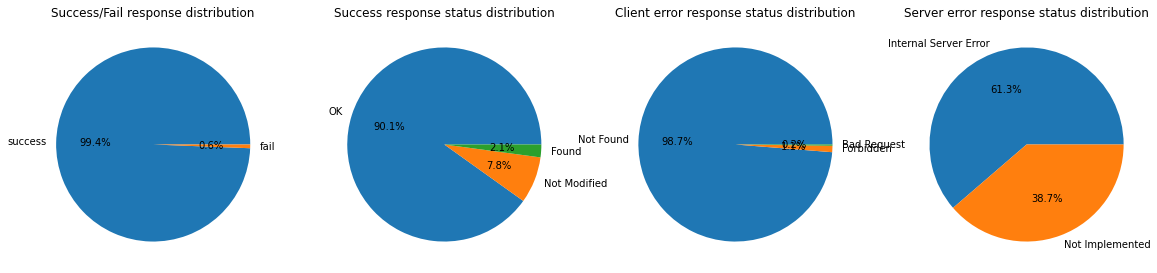

In [22]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4,figsize=(20,20))

# group by and count number of visits
df_top_responses = df_response.groupby(['result'])['result'].count().sort_values(ascending=False).reset_index(name='count')

# horizontal bar plot
labels = df_top_responses['result']
values = df_top_responses['count'] / len(df_top_responses)
ax1.pie(values, labels = labels, autopct = '%1.1f%%')
ax1.set_title('Success/Fail response distribution')

df_success_responses = df_response.loc[df_response['result'] == 'success']

# group by and count number of visits
df_success_responses = df_success_responses.groupby(['respstatus'])['respstatus'].count().sort_values(ascending=False).reset_index(name='count')

labels = df_success_responses['respstatus']
values = df_success_responses['count'] / len(df_success_responses)
ax2.pie(values,labels = labels, autopct = '%1.1f%%')
ax2.set_title('Success response status distribution')

df_fail_responses = df_response.loc[df_response['respclass'] == 'client error']

# group by and count number of visits
df_fail_responses = df_fail_responses.groupby(['respstatus'])['respstatus'].count().sort_values(ascending=False).reset_index(name='count')

labels = df_fail_responses['respstatus']
values = df_fail_responses['count'] / len(df_fail_responses)
ax3.pie(values, labels = labels, autopct = '%1.1f%%')
ax3.set_title('Client error response status distribution')

df_fail_responses = df_response.loc[df_response['respclass'] == 'server error']

# group by and count number of visits
df_fail_responses = df_fail_responses.groupby(['respstatus'])['respstatus'].count().sort_values(ascending=False).reset_index(name='count')

labels = df_fail_responses['respstatus']
values = df_fail_responses['count'] / len(df_fail_responses)
ax4.pie(values,labels = labels, autopct = '%1.1f%%')
ax4.set_title('Server error response status distribution')

plt.show()

In [23]:
# Dataframe resulting from response analysis
df_response

,response,respstatus,respclass,result
0,200,OK,successful,success
1,200,OK,successful,success
2,200,OK,successful,success
3,304,Not Modified,redirection,success
4,200,OK,successful,success
...,...,...,...,...
1569891,304,Not Modified,redirection,success
1569892,304,Not Modified,redirection,success
1569893,200,OK,successful,success
1569894,200,OK,successful,success


### Bytes
* Clean values in bytes variable
* TODO: threshold indicator to build case for potential point for improvement: CDN

Null values are replaced with 0 as it is likely that no content was returned on the 

Small percentage of 0 content reponse - 10%

In [91]:
df_bytes = pd.DataFrame(pd.to_numeric(df_cleaned_logs['bytes'], errors='coerce', downcast='integer'))

df_bytes['bytes'] = df_bytes['bytes'].fillna(0)

print('percentage of 0 content response: ', str(df_bytes[df_bytes['bytes'] == 0].count() / df_bytes.shape[0]))

percentage of non-response content:  bytes    0.090681
dtype: float64


There is a wide range of returned bytes from 28 bytes to 6MB. Standard deviation is 76KB.

In [97]:
df_bytes[df_bytes['bytes'] > 0].describe()

,bytes
count,3.147708e+06
mean,2.081652e+04
std,7.632950e+04
min,2.800000e+01
25%,1.037000e+03
50%,4.142000e+03
75%,1.185300e+04
max,6.823936e+06


For readability, the unit standard is changed from bytes to KB: Standard deviation, 25th and 50th percentile are on KB range.

In [99]:
df_bytes = df_bytes / 1000

By using box plot to understand distribution, it became evident that there are a lot of identified outliers and that most of the content density is in less than 1KB range.

There is a need to understand the distribution further and to potentially categorize the response content (e.g. S, M, L), which could potentially help with optimisation (e.g. CDN)

Also, it is notable from the graph that there is a single outlier at the 6MB mark that have influenced the disparity between the initial quantiles and box plot. However, it is not prudent to remove this outlier at the moment, given that it may still be a valid content.

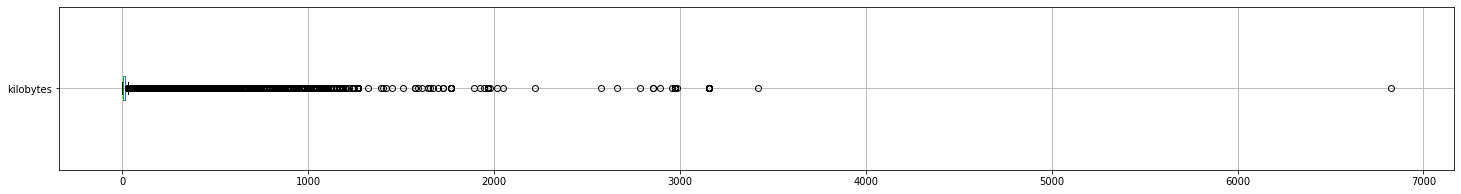

In [105]:
df_return_bytes = df_bytes[df_bytes['bytes'] > 0]
fig, ax = plt.subplots(figsize=(25,3))
ax = df_return_bytes.boxplot(column='bytes', vert=False)
ax.set_yticklabels(['kilobytes'])
plt.show()

Zooming in to the non-outlier fences that the box plot hand indicated to get a clearer view of what is defined as 'normal.

iqr:  10.815999999999999  low fence:  -15.186999999999998  high fence:  28.076999999999998
mean:  20.8165176666672 median:  4.142
mode: 0    0.786
Name: bytes, dtype: float64


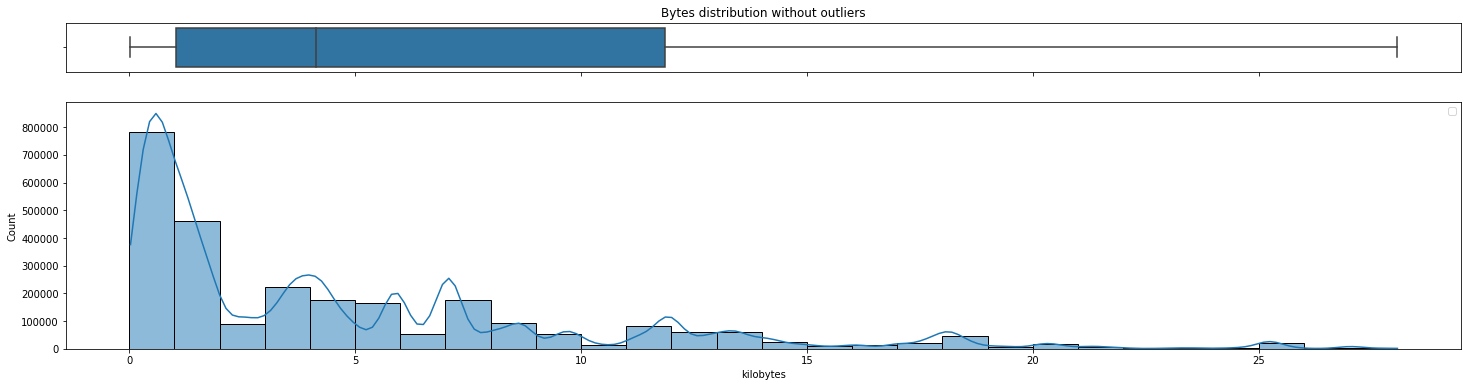

In [115]:
df_25pct_return_bytes = df_return_bytes.quantile(0.25)['bytes']
df_50pct_return_bytes = df_return_bytes.quantile(0.5)['bytes']
df_75pct_return_bytes = df_return_bytes.quantile(0.75)['bytes']

#df_1stqt_return_bytes = df_return_bytes[df_return_bytes['bytes'].le(df_25pct_return_bytes)].filter(['bytes'])
#df_2ndqt_return_bytes = df_return_bytes[df_return_bytes['bytes'].gt(df_25pct_return_bytes) & df_return_bytes['bytes'].le(df_50pct_return_bytes)].filter(['bytes'])
#df_3rdqt_return_bytes = df_return_bytes[df_return_bytes['bytes'].gt(df_50pct_return_bytes) & df_return_bytes['bytes'].le(df_75pct_return_bytes)].filter(['bytes'])

iqr = df_75pct_return_bytes - df_25pct_return_bytes #Interquartile range
fence_low = df_25pct_return_bytes - (1.5*iqr)
fence_high = df_75pct_return_bytes + (1.5*iqr)

print('iqr: ', iqr, ' low fence: ', fence_low, ' high fence: ', fence_high)
print('mean: ', df_return_bytes.mean()['bytes'])
print('median: ', df_return_bytes.median()['bytes'])
print('mode:',  df_return_bytes.mode()['bytes'])

fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(25,6), gridspec_kw= {"height_ratios": (0.2, 1)})

sns.boxplot(data=df_return_bytes, x="bytes", ax=ax_box, showfliers=False)
sns.histplot(df_return_bytes[df_return_bytes['bytes'] < fence_high], bins=np.arange(0, fence_high, 1), kde=True)

ax_box.set(xlabel='')
ax_hist.set(xlabel='kilobytes')
ax_hist.legend('')
ax_box.set_title('Bytes distribution without outliers')
plt.show()

In [78]:
df_outliers = df_return_bytes[df_return_bytes['bytes'] > fence_high]

outliers_fence_low = df_outliers.min()['bytes'] 
outliers_fence_high = df_outliers.max()['bytes']

print('OUTLIERS low fence: ', outliers_fence_low, ' high fence: ', outliers_fence_high)

OUTLIERS low fence:  28085  high fence:  6823936


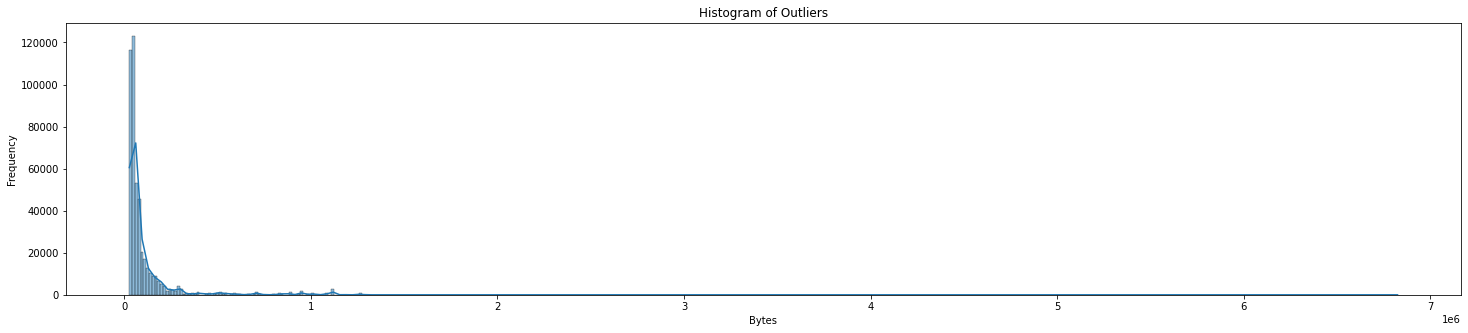

In [90]:
fig, ax2 = plt.subplots(figsize=(25,5))
# seaborn histogram
ax2 = sns.histplot(df_outliers['bytes'], kde=True, bins=np.arange(outliers_fence_low, outliers_fence_high, 15000))
# Add labels
ax2.set_title('Histogram of Outliers')
ax2.set_xlabel('Bytes')
ax2.set_ylabel('Frequency')
plt.show()

## Identify relationship between features

## Recommendations (?)